In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math as mt
import time
import sys

sys.path.insert(1, '/rds/general/user/lr4617/home/4th_Year_Project/Final_Year_Project/')

from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE_
from scipy.spatial import distance
from scipy.stats import entropy
from mPE_ultis import integrand, ubble, array_list, permutation
from util import rolling_mean, probability, probability_v2, get_mPE_matrix
from sklearn.cluster import KMeans

In [7]:
rats = np.load('/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/rats_sampling_10_window_150.npy')
lengths = np.load('/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/lengths.npy')

to_be_removed = '.ipynb_checkpoints'

root_dir = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/'
normal_trajs = os.listdir(root_dir + 'normal')
drug_trajs_1 = os.listdir(root_dir + 'caffeine')
drug_trajs_2 = os.listdir(root_dir + 'amphetamine')


if to_be_removed in normal_trajs:
    idx = normal_trajs.index(to_be_removed)
    normal_trajs.pop(idx)
    
if to_be_removed in drug_trajs_1:
    idx = drug_trajs_1drug_trajs_1.index(to_be_removed)
    drug_trajs_1.pop(idx)

if to_be_removed in drug_trajs_2:
    idx = drug_trajs_2.index(to_be_removed)
    drug_trajs_2.pop(idx)

names = normal_trajs + drug_trajs_1 + drug_trajs_2

print(rats.shape)

(6480000, 60)


In [3]:
def mPE__(*argv):    
    g=len(argv)
    
    if g==2:
        n=argv[1]
        datain=argv[0]
        lamin=np.array([1])
        epsin=np.array([1])
    if g==3:
        n=argv[1]
        datain=argv[0]
        lamin=np.array([1])
        epsin=argv[2]
    if g==4:
        n=argv[1]
        datain=argv[0]
        lamin=argv[3]
        epsin=argv[2]
    
#    Check for the data to be in the right dimension        
    if datain.shape[0] == 1 or datain.shape[1] == 1:
        if len(datain[:,0])>len(datain[0,:]):
            datain=datain.transpose()
    else:
        if len(datain[:,1])>len(datain[1,:]):
            datain=datain.transpose()
        
    scalesno=len(epsin)
    lagno=len(lamin)
    HH=np.zeros((lagno,scalesno))
    norm_HH=np.zeros((lagno,scalesno))
#    Definition of parameters: fac is the number of possible permutations
#    Elem is the No of data points
#    Dim is the dimensionality of the samples
    
    for lam in range(0,lagno):
        for eps in range(0,scalesno):
            scale=epsin[eps]
            L=lamin[lam]
            xlen=len(datain[0,:])
            ylen=np.round((xlen/scale)-0.5)
            ylen=ylen.astype(int)
            D=np.zeros((len(datain[:,0]),ylen))
            for ylenc in range(0,ylen):
                dfg=datain[:,((ylenc)*scale):((ylenc+1)*scale)]
                fhk=np.sum(dfg,axis=1)
                r=(1/scale)*fhk
                D[:,ylenc]=r
                
            data=D
            fac=mt.factorial(n)
            elem=len(data[0,:])
            dim=len(data[:,0])
            
        #    A is a n-by-factorial(n) matrix that shows all the 
        #    possible permutations of n elements
            A=permutation(n)
            
        #    counter is a factorial(n) square matrix that counts the recurrence of
        #    a dim-dimensional permutation
            lpi=fac*np.ones((dim))
            lpi=lpi.astype(int)
            nj = lpi.tolist()
            counter=np.zeros((nj))
            
        #    For each iteration i, a series of n points is sampled from the 
        #    data set and the corresponding permutation is identified. 
        #    The counter matrix keeps track of the numiber of times a certain
        #    permutation, or combination of permutations is observed. 
            for i in range(0, elem-n*L+L-1):
                coord=np.zeros((dim))
                for num in range(0,dim):
                    sample=data[num,range(i,i+L*(n),L)]
                    ord=ubble(sample)
                    perm_num=0
                    check_1=1
                    check_2=1
                    
                    while (perm_num<=fac) and (check_2):
                       
                        check_1=1
                        for j in range(0,n-1):
                            if ord[j]!=A[perm_num,j]:
                                check_1=0
                        if check_1:
                            coord[num]=perm_num
                            check_2=0
                            
                        perm_num=perm_num+1
                
                    
                coord=coord.astype(int)
                coord1=tuple(coord)
                counter[coord1]=counter[coord1]+1
                
        #    Once the counter matrix is complete, each element is divided by the
        #    total number of samples to get a empirical probability, and the PE is
        #    computed according to the method described in Schurmann
            
            H=0
            counter1=counter.flatten()
            for iter in range(0,(fac**dim)):
               
                rec=counter1[iter]
                tot=elem-n+1
                
                if rec==0:
                    H=H
                    
                else:
                    I = quad(integrand, 0, 1, args=(rec))
                    I=I[0]
                    coeff=((-1)**rec)*I
                    prob=(rec/tot)*(psi.digamma(tot)-psi.digamma(rec)-coeff)
                    H=H+mt.log2(mt.exp(prob))
                 
        #     The normalised entropy norm_H is computed as well
            norm_H=H/(mt.log2(fac**dim))
            
            HH[lam,eps]=H
            norm_HH[lam,eps]=norm_H
    return [HH,norm_HH]

In [4]:
def get_mPE_matrix_(reduced_traj, bins_number, traj_number, orders, random):
    if random:
        bins_number = 2
        mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
        traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
        print(mPE_vector.shape)

        for i in range(bins_number):
            idx = 0
            for j in range(0, traj_length*traj_number, traj_length):
                idx_1 = np.random.randint(np.max(reduced_traj.shape) - traj_length)
                traj = reduced_traj[idx_1: idx_1 + traj_length]
                [HH, _]=mPE__(traj, orders[0])
                mPE_vector[i, idx, 0] = HH
                idx +=1

    else:
        mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
        traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
        
        for a, order in enumerate(orders):
            
            for i in range(bins_number):
                idx = 0
                
                for j in range(0, traj_length*traj_number, traj_length):
                    idx_1 = i*traj_number*traj_length 
                    traj = reduced_traj[idx_1 + j: idx_1 + j + traj_length]
                        
                    if traj.shape[0]>0:
                        [HH, _]=mPE__(traj, order)
                        mPE_vector[i, idx, a] = HH
                        
                    idx +=1
    
    return mPE_vector

normal traj_5
########################## APPLY PCA ##########################


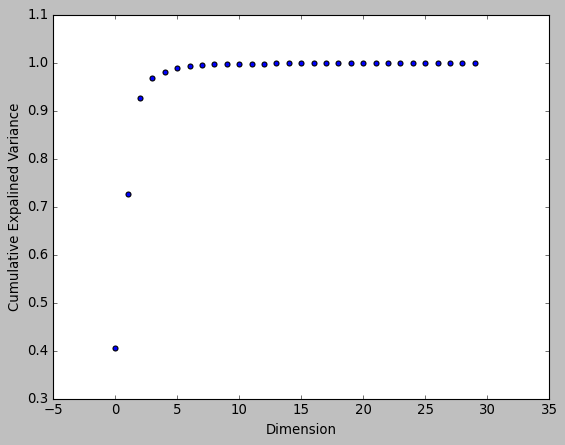

signal shape:  (334800, 3)
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend 

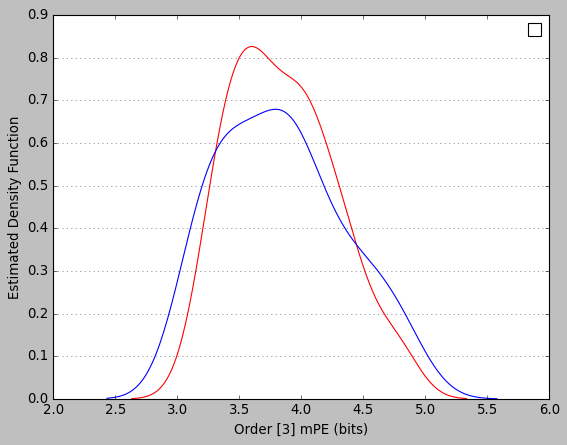

0.7695107143065164 0.406268795427224
normal traj_3
########################## APPLY PCA ##########################


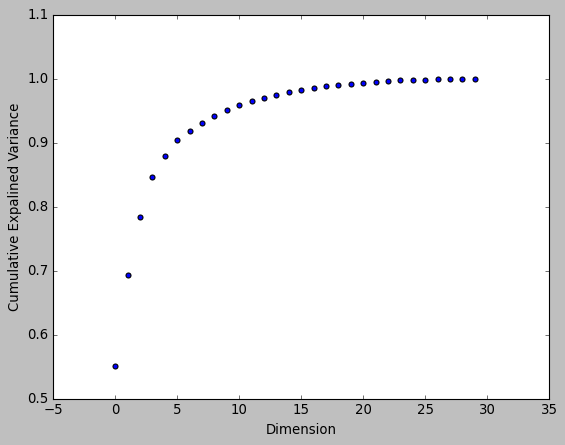

signal shape:  (334800, 3)
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend 

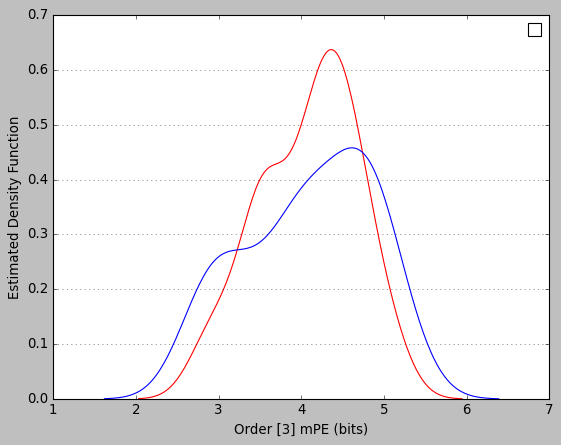

0.6102226105623011 0.4139243658815989
normal traj_2
########################## APPLY PCA ##########################


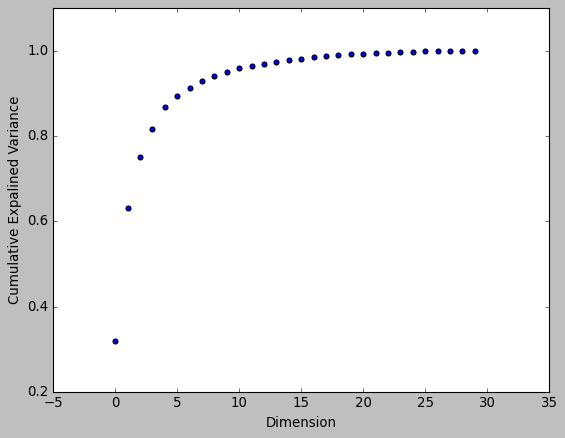

signal shape:  (334800, 3)
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend 

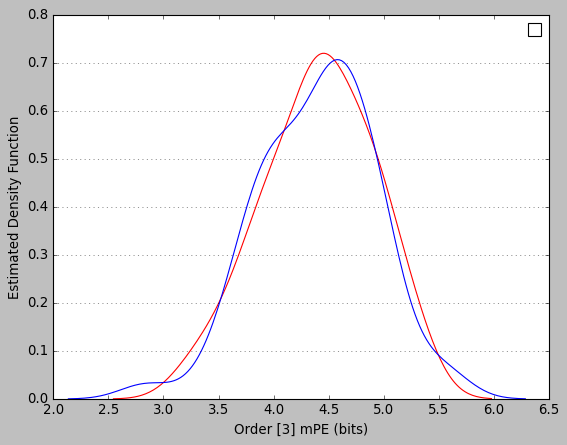

0.9030745921833321 0.3878157121106592
normal traj_1
########################## APPLY PCA ##########################


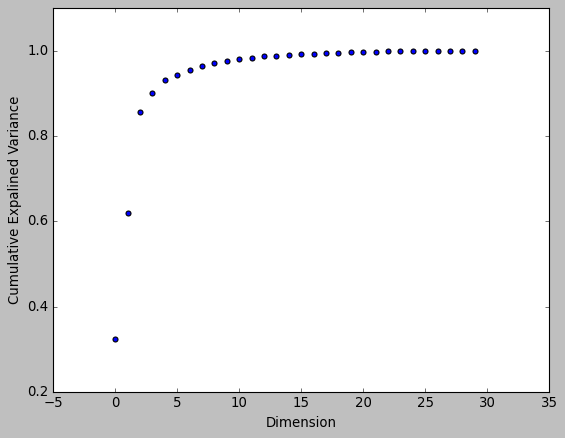

signal shape:  (334800, 3)
(1339200, 3)
########################## CONTROL ANALYSIS ##########################
(2, 223, 1)
0.3317223562178838
(2, 223, 1)
0.3938934856382681
0.3938934856382681 0.1430608718700523
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend 

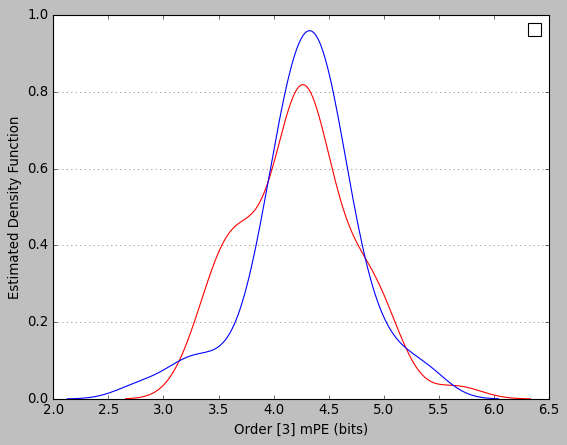

0.2225456491792584 0.4570314383494637
caffeine traj_8
########################## APPLY PCA ##########################


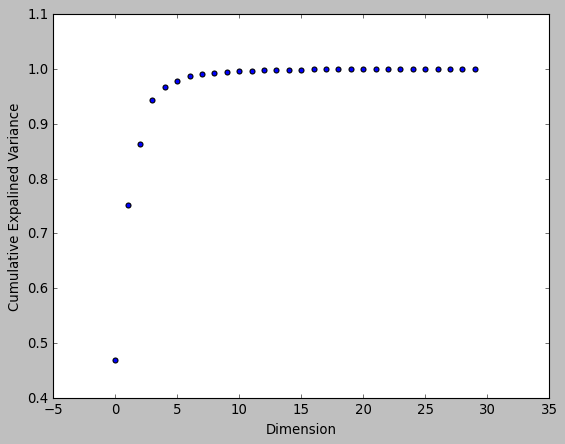

signal shape:  (334800, 3)
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend 

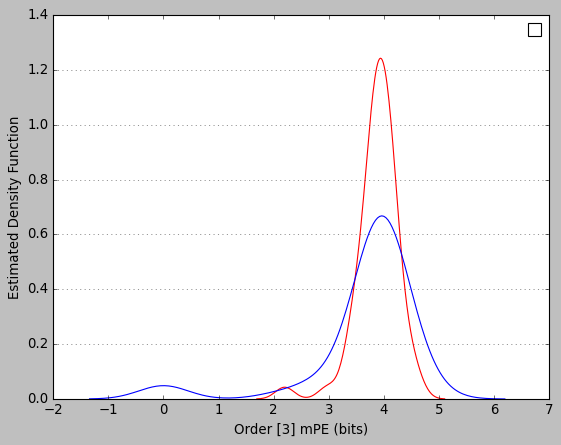

0.9030745921833321 0.44847827224580855
caffeine traj_4
########################## APPLY PCA ##########################


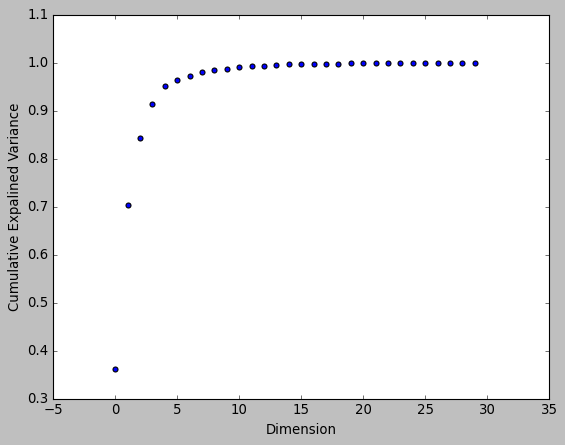

signal shape:  (334800, 3)
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend 

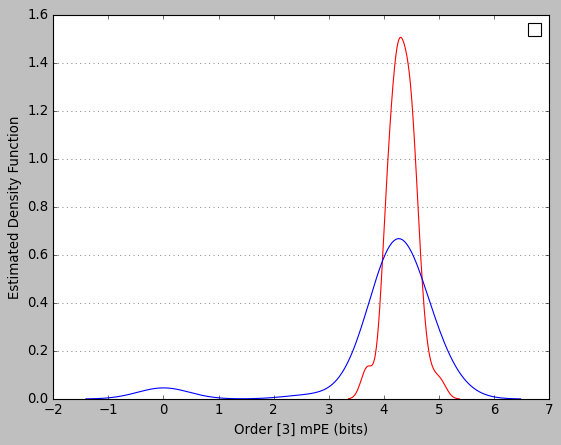

0.09251790142202007 0.469994327937135
caffeine traj_2
########################## APPLY PCA ##########################


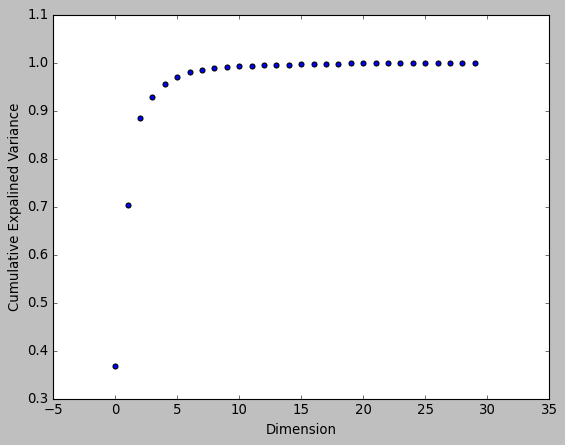

signal shape:  (334800, 3)
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend 

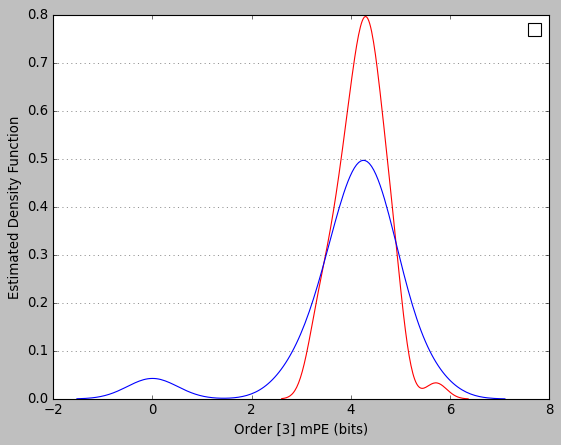

0.7695107143065164 0.40953261305018257
caffeine traj_6
########################## APPLY PCA ##########################


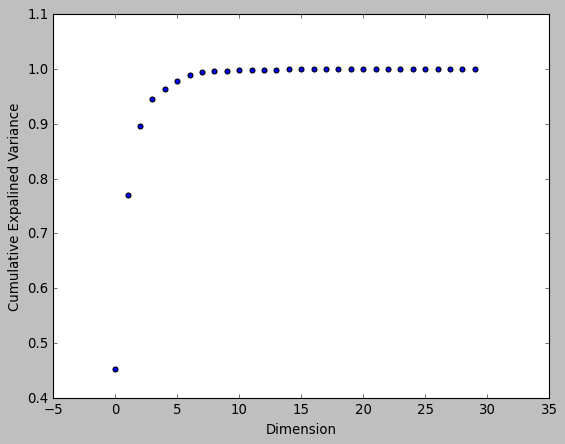

signal shape:  (334800, 3)
(1339200, 3)
########################## CONTROL ANALYSIS ##########################
(2, 223, 1)
0.4626545708336164
0.4626545708336164 0.13270199406943667
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend 

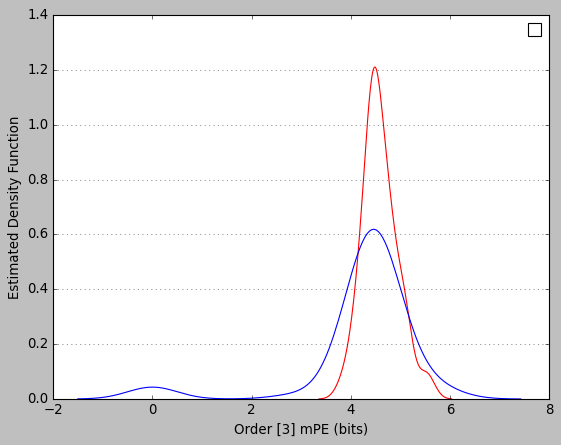

0.2225456491792584 0.37442791600336534
amphetamine traj_5
########################## APPLY PCA ##########################


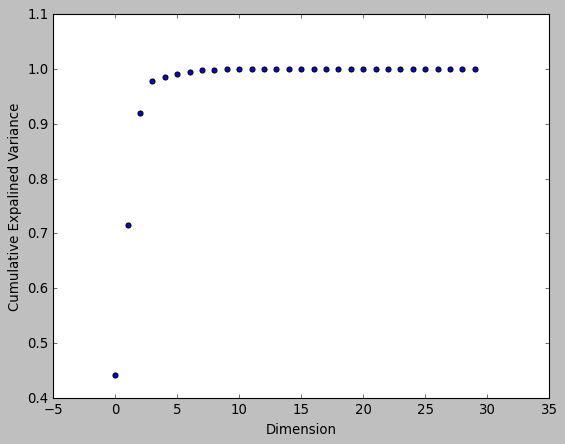

signal shape:  (334800, 3)
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend 

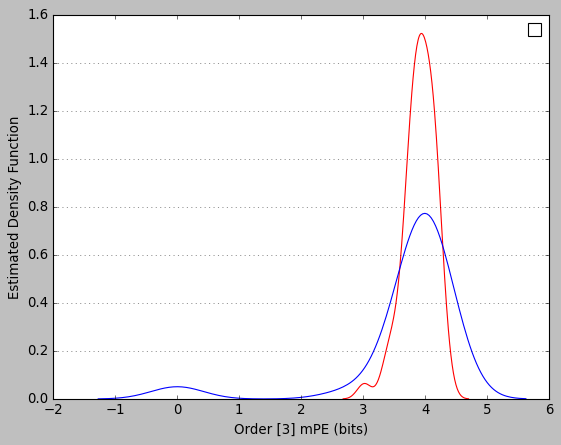

0.4565099623459808 0.42235908415743145
amphetamine traj_3
########################## APPLY PCA ##########################


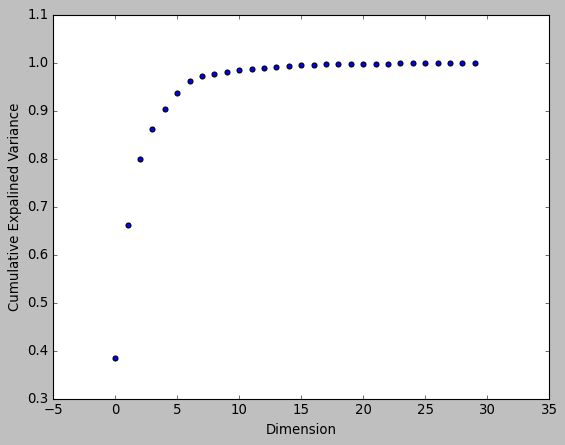

signal shape:  (194400, 3)
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend 

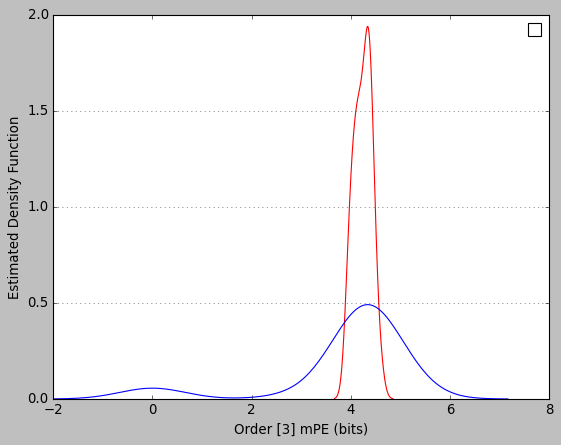

0.16006945300221284 0.5528967616548024
amphetamine traj_7
########################## APPLY PCA ##########################


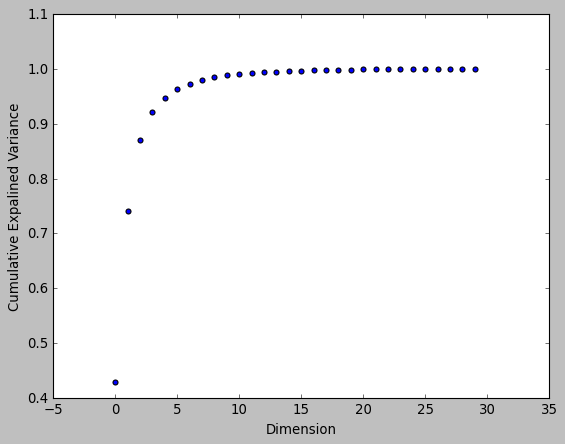

signal shape:  (334800, 3)
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend 

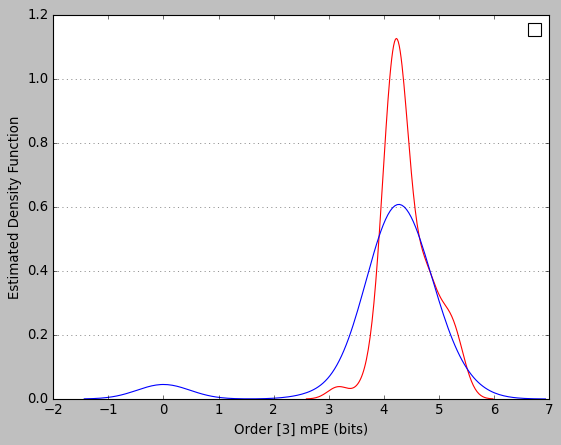

0.09251790142202007 0.49604080234202763
amphetamine traj_1
########################## APPLY PCA ##########################


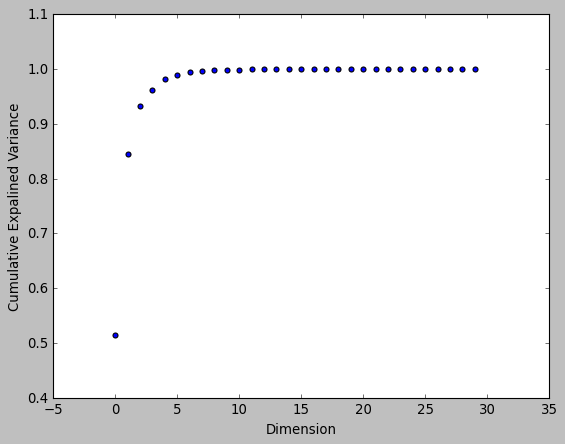

signal shape:  (334800, 3)
(1198800, 3)
########################## CONTROL ANALYSIS ##########################
(2, 199, 1)
0.2181191079906527
(2, 199, 1)
0.9638560810364151
0.9638560810364151 0.16947941261617594
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: Legend 

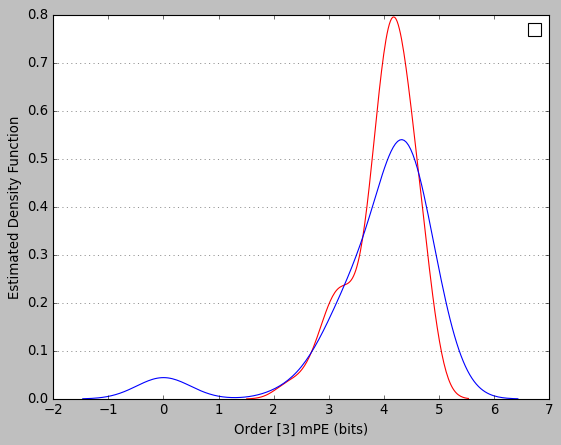

0.1462734997339796 0.4384913867272845


In [6]:
###################################################################################################################################################
####################################################################### PCA #######################################################################
###################################################################################################################################################

decimals = 3
n_clusters_kmeans = 30
unit_length_entropy = 3000
save = True
nPCs = [3]
max_length = 334800

use_all = False ## DONE
use_partition_up = False ## DONE
use_partition_down = True ## DONE
use_single = False ## DONE

if use_single:
    nPCs = [3]
    dims = np.arange(9,12)
    use_PCA = False
    add_on = '_marker'

if use_partition_up:
    nPCs = [3]
    dims_1 = np.arange(24)
    dims_2 = np.arange(36,42)
    use_PCA = True
    add_on = '_partition_up'
    
    dims = np.concatenate((dims_1,dims_2), axis=0)

if use_partition_down:
    nPCs = [3]
    dims_1 = np.arange(24,36)
    dims_2 = np.arange(42,60)
    use_PCA = True
    add_on = '_partition_down'
    
    dims = np.concatenate((dims_1,dims_2), axis=0)
    
if use_all:
    dims = np.arange(60)
    use_PCA = True
    

for n_PC in nPCs:
    
    count = 0
    measures = np.zeros((5, 100))    
    # consists of:
    # - explained variance
    # - p-value (control)
    # - j-s (control)
    # - p-value(result)
    # - j-s (result)

    
    for which_traj, length in enumerate(lengths):
        
        ##### formatting for name #####
        if count <= 3:
            mode = 'normal'
        elif count >= 4 and count <=7:
            mode = 'caffeine'
        else:
            mode = 'amphetamine'
        
        name = names[count]
        print(mode, name)

        ##### retireving single trajectory #####
        if which_traj == 0:
            idx = 0
        else:
            idx += lengths[which_traj-1]

        traj = rats[idx:idx+length, dims]

        ##### PCA #####
        if use_PCA:
            print('########################## APPLY PCA ##########################')

            pca = PCA()
            pca.fit(traj)

            ##### save explained variance #####
            measures[0, 0:len(pca.explained_variance_ratio_)] = pca.explained_variance_ratio_

            explained_var_plot = [np.sum(pca.explained_variance_ratio_[0:i+1]) for i in range(len(pca.explained_variance_ratio_))]
            plt.scatter(np.arange(traj.shape[1]), explained_var_plot)
            plt.ylabel('Cumulative Expalined Variance')
            plt.xlabel('Dimension')

            ##### IMAGES ARE SAVED IN TRAJECTORY FOLDER #####
            path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time' + str(add_on) + '/macro/' + str(n_PC) + 'PC/control/' + mode + '/' + name + '/'
            name_out = mode + '_explained_var_' + name
            # plt.savefig(path_out +  name_out  + ".png")
            plt.show()

            # reduce data according to explained variance values using linear PCA
            pca = PCA(n_components=n_PC)
            reduced_traj = pca.fit_transform(traj)
            if reduced_traj.shape[0] > max_length:
                reduced_traj = reduced_traj[0:max_length, :]

        else:
            if traj.shape[0] > max_length:
                reduced_traj = traj[0:max_length, :]
        
        print('signal shape: ', reduced_traj.shape)
        
        ##### Control vector assemble #####
        if count == 0 or count ==  4 or count == 8:
            control_vector = reduced_traj
        else:
            control_vector = np.concatenate((control_vector, reduced_traj),axis=0)

        ###################################################################################################################################################
        ########################################################### CONTROL ANALYSIS ######################################################################
        ###################################################################################################################################################
        
        ########## Take random trajectories and check that they have approximately the same mPE ##########
        
        if count == 3 or count ==  7 or count == 11:
            
            print(control_vector.shape)
            print('########################## CONTROL ANALYSIS ##########################')

            ########## params ##########
            unit_length = unit_length_entropy
            bins_number = 2
            bin_length = int(control_vector.shape[0]/bins_number)
            traj_number = int(bin_length/unit_length)
            orders = [3]
            random = True

            too_low = True

            while too_low:

                mPE_vector = get_mPE_matrix_(control_vector, bins_number, traj_number, orders, random)

                ########## Calculate p-value ##########
                [_, p_value] = stats.ks_2samp(mPE_vector[0, :, 0], mPE_vector[1, :, 0])

                print(p_value)

                if p_value > 0.35:
                    too_low = False
                    break

            path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time' + str(add_on) + '/macro/' + str(n_PC) + 'PC/control/' + mode + '/'
            name_out = 'mPE_control_' + name
            
            if save:
                np.save(path_out + name_out, mPE_vector)

            ########## Retrieve maxiumum number of elements based on k-means clustering ##########
            data = np.concatenate((np.transpose(mPE_vector[0, :, :]), np.transpose(mPE_vector[1, :, :])), axis = 1)
            kmeans = KMeans(n_clusters=20).fit(data.reshape(-1,1))
            kmeans.predict(data.reshape(-1,1))
            centroids = kmeans.cluster_centers_
            centroids = [centroids[i] for i in range(len(centroids))]
            centroids = np.asarray(centroids)

            ########## Get probability vectors ##########
            prob1 = probability_v2(mPE_vector[0, :, 0], centroids)
            prob2 = probability_v2(mPE_vector[1, :, 0], centroids)

            ########## Evaluation ##########
            js_distance = distance.jensenshannon(prob1, prob2)

            print(p_value, js_distance)
            measures[1, 0] = p_value
            measures[2, 0] = js_distance

        ###################################################################################################################################################
        ########################################################### ENTROPY ANALYSIS ######################################################################
        ###################################################################################################################################################


        print('########################## ENTROPY ANALYSIS ##########################')

        ########## Entropy Calculation ##########
        unit_length = unit_length_entropy
        sub_fs = int(300/60)
        bins_number = 2
        traj_number = int(reduced_traj.shape[0]/2/unit_length)
        orders = [3]

        mPE_vector = get_mPE_matrix(reduced_traj, bins_number, traj_number, orders, random=False)
        path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time' + str(add_on) + '/macro/' + str(n_PC) + 'PC/result/' + mode + '/mPE_result_' + name + '.npy'
        if save:
            np.save(path_out, mPE_vector)

        ########## Retrieve maxiumum number of elements based on k-means discretization ##########
        data = mPE_vector.flatten()
        kmeans = KMeans(n_clusters=n_clusters_kmeans).fit(data.reshape(-1,1))
        kmeans.predict(data.reshape(-1,1))
        centroids = kmeans.cluster_centers_
        centroids = [centroids[i] for i in range(len(centroids))]
        centroids = np.asarray(centroids)

        prob1 = probability_v2(mPE_vector[0, :, 0], centroids)
        prob2 = probability_v2(mPE_vector[1, :, 0], centroids)

        js_distance = distance.jensenshannon(prob1, prob2)
        [stat, p_value] = stats.ks_2samp(mPE_vector[0, :, 0], mPE_vector[1, :, 0])

        ########## plotting mPE continuous distribution as a function of time ##########        
        fig = plt.figure()
        c = ['r', 'b']
        for bin_n in range(bins_number):
            ax = sns.kdeplot(mPE_vector[bin_n, :, 0], color=c[bin_n])

        plt.legend('first_half', 'second_half')
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Order [3] mPE (bits)')
        plt.ylabel('Estimated Density Function')

        path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time' + str(add_on) + '/macro/' + str(n_PC) + 'PC/result/' + mode + '/' + name + '/'
        name_out = mode + '_result_' + name

        # plt.savefig(path_out +  name_out  + ".png")    
        plt.show()

        print(p_value, js_distance)
        measures[3, 0] = p_value
        measures[4, 0] = js_distance

        count +=1